# GCR access

Owners: **PatriciaLarsen [@plarsen](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@patricialarsen)**  
Last Verifed to Run: **2024-06-04** (by @plarsen)

This notebook will show you how to access the DP0.2 object catalog through the Generic Catalog Reader (GCR, https://github.com/yymao/generic-catalog-reader), or directly through the parquet files at nersc. We will talk through how to look at the metadata, and discuss how to read the data in an efficient manner. 


__Learning objectives__:

After going through this notebook, you should be able to:
  1. Load and efficiently access the DP0.2 object catalog with the GCR
  2. Access the catalog schema through the GCR
  3. Apply cuts to the catalog using GCR functionalities
  4. Access the DP0.2 object catalog directly using parquet functions for more advanced read-in options

__Sections__:
 - Accessing the object catalog with the GCR
 - Reading the data through the GCR

__Logistics__: This notebook is intended to be run through the JupyterHub NERSC interface available here: https://jupyter.nersc.gov. To setup your NERSC environment, please follow the instructions available here: https://confluence.slac.stanford.edu/display/LSSTDESC/Using+Jupyter+at+NERSC


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys
import time

## Accessing the object catalog with the GCR

The [GCRCatalogs](https://github.com/LSSTDESC/gcr-catalogs) package is a DESC project which aims at gathering in one convenient location various simulation/data catalogs made available to the collaboration.  

In this section, we illustrate how to use this tool to access the object catalogs from DC2 Run2.2i that the Rubin project ran using the DMStack, DP0.2 (data preview 0.2).

In [3]:
sys.path.insert(0,'/global/cfs/projectdirs/lsst/groups/SRV/gcr-catalogs-test')
import GCRCatalogs

# Load the object catalog
catalog = GCRCatalogs.load_catalog('lsst_object_full')

A significant numbers of cosmology catalogs besides the DP0.2 object catalogs are also available through the GCR, use `sorted(GCRCatalogs.get_available_catalogs(False))` to see a full list and visit the [DC2 Data Product](https://confluence.slac.stanford.edu/display/LSSTDESC/DC2+Data+Product+Overview) page to see all the DC2-related catalogs.

### DP0.2 object catalog Schema

The quantities available in the catalog can be found on the project website here: https://dm.lsst.org/sdm_schemas/browser/dp02.html, but we can also access these from the GCR in the following way. Note that these methods are equivalent, for this specific catalog named lsst_object we have done no quantity translation and so it's safe to assume that these follow the lsst conventions exactly. 

Note that for comparisons between the DP0.2 and DC2 object catalogs you may prefer to use a translation layer to convert the DP0.2 catalog into DC2 conventions before read-in, this is available by using dp02_object rather than lsst_object. We will cover the use of the translated catalog in a different tutorial. 


In [4]:
quantity_list = sorted(catalog.list_all_native_quantities())
for i in range(4):
    q = quantity_list[i]
    info = catalog.get_quantity_info(q)
    print(q)
    print('------------------')
    print(info['description'])
    print('Type: ' + info['type'] + ',', 'Units: ' + info['unit'])
    print(' ')

coord_dec
------------------
Fiducial ICRS Declination of centroid used for database indexing
Type: double, Units: deg
 
coord_ra
------------------
Fiducial ICRS Right Ascension of centroid used for database indexing
Type: double, Units: deg
 
deblend_nChild
------------------
Number of children this object has (defaults to 0)
Type: int32, Units: none
 
deblend_skipped
------------------
Deblender skipped this source
Type: boolean, Units: none
 


## Accessing the dataset through the GCR

Typically in the GCR we list the quantities we require, filters we want to cut these on, and any native filters we want to cut on. Native filters define the set of files to include within the group so tend to result in a more efficient filter.  

### Notation and format
- Filters are defined using strings as shown, these are converted to parquet formatting through the reader 
- Native_filters are limited to a tract or list of tracts (e.g. tract==4430 or tracts==[4430,4431])
- specifying return_iterator=True will return the data iteratively, for this catalog we combine the files into a pyarrow dataset and iterative outputs are computed using the default to_batches method. 
- The notation matches that of the standard GCR methods, but you might find this catalog reads in a little faster. This is mostly because it makes use of advances in the pyarrow package which result in an improved read-in time. 
- **note that native_filters currently doesn't work on this dataset, I need to pass the native quantities through in a different spot before the iterative read**

9.0 seconds to read the data


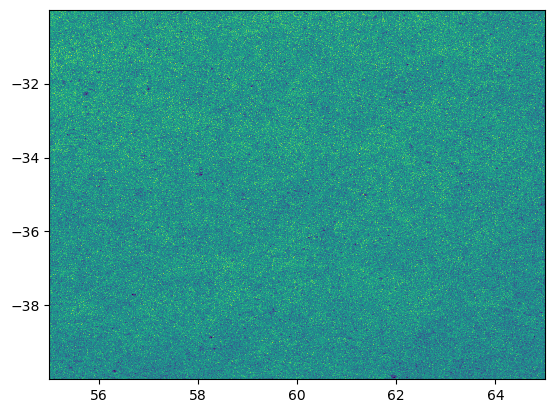

In [10]:
time_start = time.time()

filters = ['detect_isPrimary', "r_ra > 55", "r_decl < -30", 'r_ra < 65','r_decl > -40']
data = catalog.get_quantities(["r_ra","r_decl"], filters =filters, native_filters=['tract== 4430'])  

time_end = time.time()

print(np.round(time_end-time_start), 'seconds to read the data')
plt.figure()
plt.hist2d(data["r_ra"],data["r_decl"],bins=1000)
plt.show()